**Klasifikasi SVM dengan Data Dummy**

In [1]:
# import library
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

Pada kegiatan ini, model yang digunakan adalah sebuah model yang sederhana berupa generative model untuk menentukan label pada poin baru. Kasus pada data dummy ini memperlihatkan dua kelas yang telah terpisah.

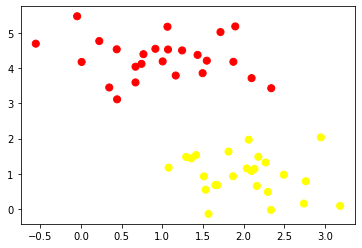

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

Untuk membuat sebuah model klasifikasi, garis pemisah data dari dua buah himpunan yang terbentuk diperlukan. Namun, kondisi ini masih menyisakan kasus dimana garis pemisah yang dibutuhkan lebih dari satu garis.

(-1.0, 3.5)

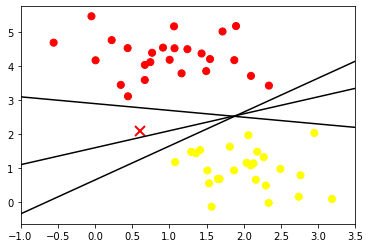

In [3]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5)

Margin dalam suatu garis juga dapat digunakan untuk memperjelas posisi sebuah data terhadap label.

(-1.0, 3.5)

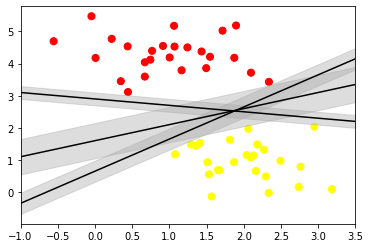

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5)

**Penerappan fitting SVM**

In [5]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.
On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.

In [6]:
# buat sebuah fungsi untuk menampilkan fitting data

def plot_svc_decision_function(model, ax=None, plot_support=True):
    
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # buat grid untuk evaluasi model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot batas dan margin
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

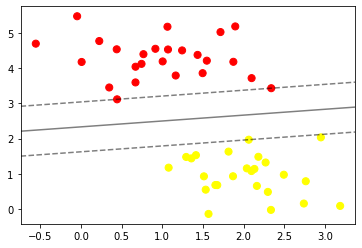

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model)

Beberapa titik data yang menyentuh (masuk ke area) garis disebut sebagai support vector.

In [8]:
# untuk mengetahui data yang masuk ke dalam support vector dapat dilakukan dengan memanggil support_vectors_

model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

Hasil fitting merupakan kunci keberhasilan suatu classifier (yang hanya dilihat dari posisi dari support vector). Data-data lain yang berada jauh dari margin dan tetap berada di area yang tepat tidak memiliki kemampuan untuk memodifikasi fitting (karena bukan support vector). Data-data tersebut tidak berkontribusi terhadap loss function yang digunakan untuk fitting model. Untuk lebih memahami hal ini, 60 dan 120 data awal digunakan sebagai contoh dalam bentuk perbandingan.

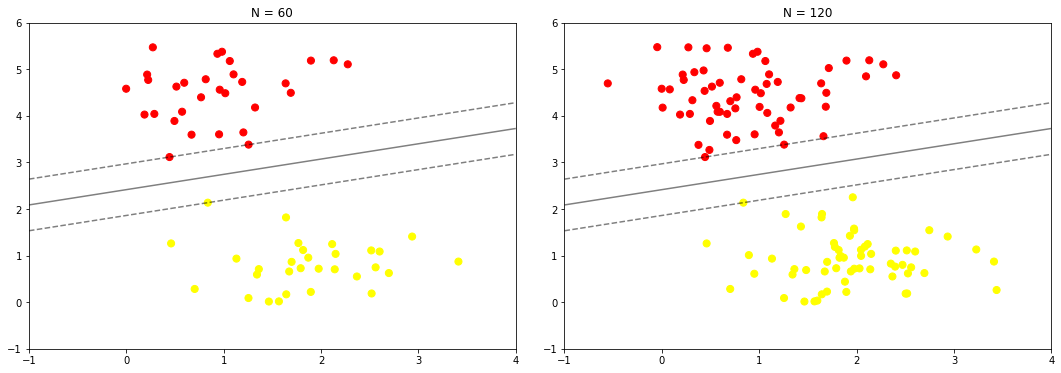

In [9]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

**Data Tidak Terpisah Secara Linier**

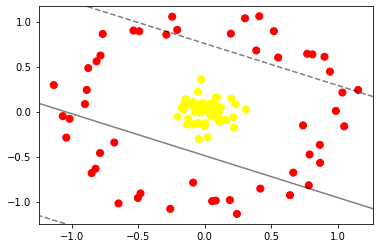

In [10]:
# contoh data tidak terpisah secara linier

from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

Berdasarkan contoh data di atas, tidak ditemukan sebuah garis pemisah linier yang mampu berperan sebagai pemisah data. Oleh karena itu, proyeksi (sudut pandang) lain terhadap data diperlukan supaya data dapat terpisahkan dengan jelas. Pada kegiatan ini, proyeksi yang digunakan adalah proyeksi berbasis radial.

In [11]:
r = np.exp(-(X ** 2).sum(1))

Karena proyeksi radial tidak cukup menggunakan model 2D, maka plot visualisasi diubah menjadi model 3D.

In [19]:
from mpl_toolkits import mplot3d
from ipywidgets import interact
from ipywidgets import fixed

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 45, 30, 20 , 10], azip=(-180, 180),
         X=fixed(X), y=fixed(y))

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 45, 30, 20 , 10], azip=(-180, 180),
         X=fixed(X), y=fixed(y))

interactive(children=(Dropdown(description='elev', index=2, options=(-90, 45, 30, 20, 10), value=30), IntSlide…

interactive(children=(Dropdown(description='elev', index=2, options=(-90, 45, 30, 20, 10), value=30), IntSlide…

<function __main__.plot_3D(elev=30, azim=30, X=array([[-0.88820336,  0.24076145],
       [-0.78805091, -0.46117631],
       [-0.1743632 ,  0.04112497],
       [ 0.78214672, -0.81916679],
       [ 1.03480739,  0.21154045],
       [ 0.30203775,  1.03644388],
       [ 0.08036282,  0.15498772],
       [-0.08033746,  0.06811635],
       [ 0.21996841, -0.17875389],
       [-1.04215193, -0.28900289],
       [-0.85183263, -0.68407937],
       [ 0.80935635,  0.63558515],
       [ 0.7388975 , -0.15364406],
       [-0.08690399, -0.14240366],
       [ 0.10662309, -0.10590202],
       [ 0.18847939, -0.9837231 ],
       [ 0.6652415 , -0.67853911],
       [-0.04546231, -0.30516493],
       [-0.14540805,  0.06753594],
       [ 0.09758426, -0.08166382],
       [ 0.04495927, -0.04993256],
       [-0.90165966,  0.08310152],
       [-0.48398684, -0.90966357],
       [ 0.01986006, -0.28598915],
       [ 0.2147065 , -0.06321944],
       [-0.64942857, -1.02087843],
       [-0.08338632,  0.06144264],
       [

Walaupun data dapat ditampilkan secara terpisah. Proyeksi titik data sejumlah N ke dalan suatu dimensi N menyebabkan beban komputasi juga bertambah. Untuk mengatasi hal ini, kernel radial basis function (RBF) pada Scikit-Learn digunakan.

In [20]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

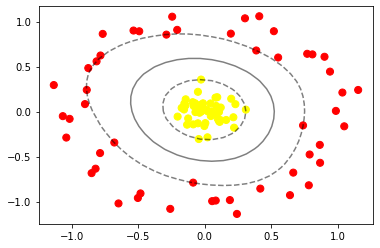

In [21]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none')

**Data Overlap**

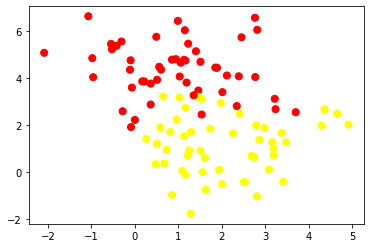

In [22]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

Untuk mengatasi hal ini, teknik penghalusan margin pada SVM dapat diterapkan. Teknik ini berfungsi untuk memasukkan beberapa titik data ke dalam margin supaya menghasilkan fitting yang lebih baik. Penebalan margin dari hasil teknik penghalusan dikelola oleh sebuah parameter tuning (dikenal sebagai C). Contoh dibawah menunjukkan perubahan pada C berdampak pada hasil fitting final.

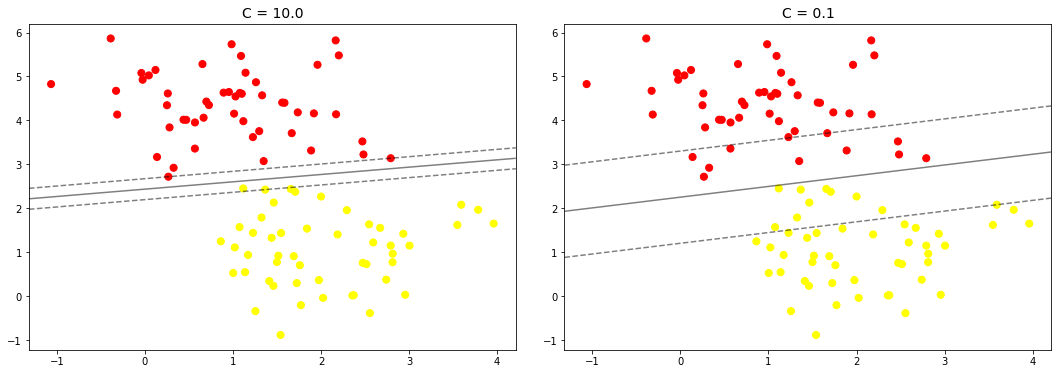

In [23]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)